## Grasping force estimation 

This code demonstrates how to open the database of EMG signals and grasping force signals. It provides a guide on performing model estimation in state space and applying the Kalman filter to achieve variance minimization, thereby improving the model estimation. The methodology is detailed in the paper titled "Grasping Force Estimation Using State-Space Model and Kalman Filter," published in Biomedical Signal Processing and Control.

For further details, refer to the paper: Grasping Force Estimation Using State-Space Model and Kalman Filter.

doi: https://doi.org/10.1016/j.bspc.2021.103036

### Import libraries

In [3]:
import os, sys
processing_source_path = os.path.abspath('./Processing/')
sys.path.append(processing_source_path)
import ProcessingPipeline as pp

In [4]:
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt 
import scipy.io

## Using EMG Dataset

####  Read the datalog file that is in " .m " extension 


In [5]:
mat = scipy.io.loadmat('EMG_force_datalog/recording_force_v3.mat')     
emg = mat['emg'];
force=  mat['Force'];
Ts= 0.005;

#### Define th Signal EMG with the imput signal 


In [6]:
u1=emg[:,0];
u2=emg[:,1];
u3=emg[:,2];
u4=emg[:,3];
u5=emg[:,4];
u6=emg[:,5];
u7=emg[:,6];
u8=emg[:,7];
U=[u1,u2,u3,u4,u5,u6,u7,u8]
n_channels= len(U)

#### Define the grasping force with the output signal 

In [7]:
y=force;
y.shape=(-1,1)
nit=y.shape[0]

#### Sample time and recording time settings

In [8]:
# sample time 

Ts=0.005
# datalog recording time 
t  =np.linspace(1, Ts*nit-Ts, nit)

### Plot the EMG and Force signals

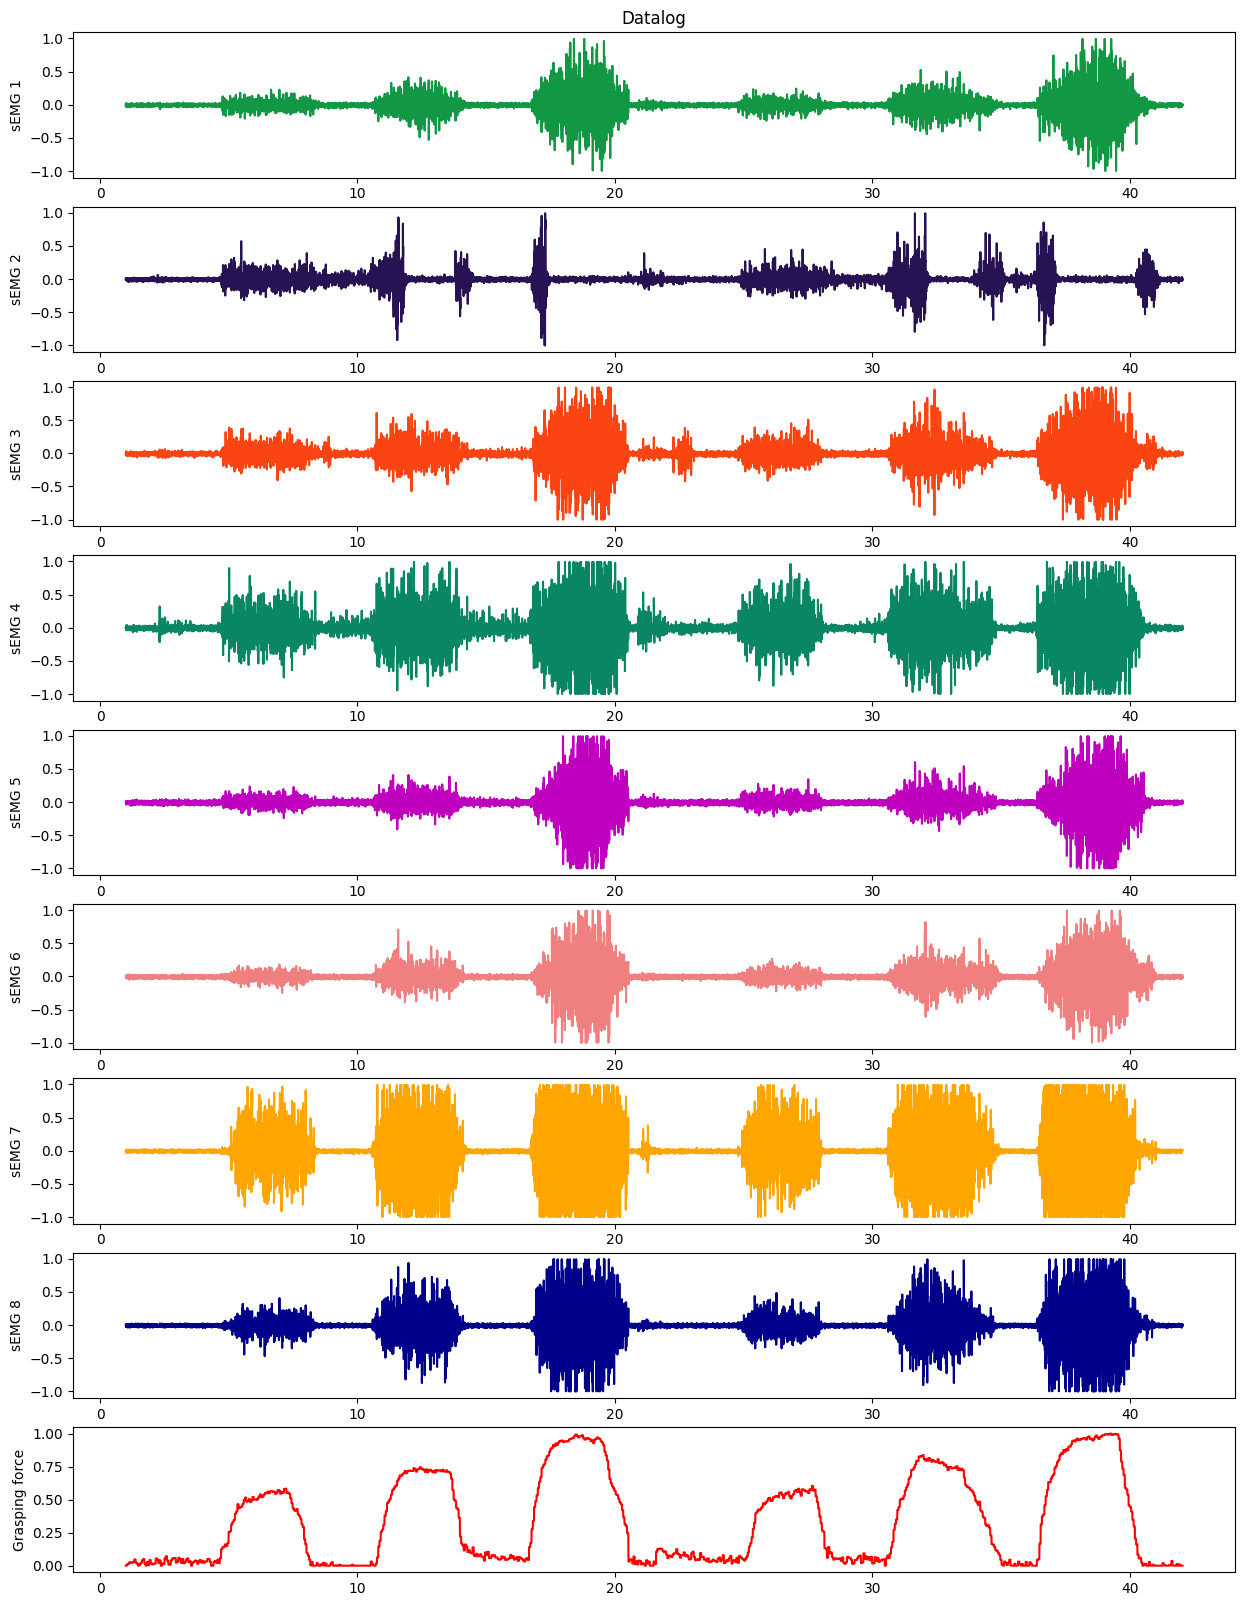

In [9]:
#plt.style.use('dark_background')
fig, axs = plt.subplots(9, 1, figsize=(15, 20))

axs[0].set_title('Datalog')
axs[0].plot(t, u1, '#129845')
axs[0].set_ylabel('sEMG 1')
axs[0].set_xlabel('Time(s)')

axs[1].plot(t, u2, '#271254')
axs[1].set_ylabel('sEMG 2')

axs[2].plot(t, u3, '#FA4411')
axs[2].set_ylabel('sEMG 3')

axs[3].plot(t, u4, '#098765')
axs[3].set_ylabel('sEMG 4')

axs[4].plot(t, u5, 'm')
axs[4].set_ylabel('sEMG 5')

axs[5].plot(t, u6, 'lightcoral')
axs[5].set_ylabel('sEMG 6')

axs[6].plot(t, u7, 'orange')
axs[6].set_ylabel('sEMG 7')

axs[7].plot(t, u8, 'darkblue')
axs[7].set_ylabel('sEMG 8')

axs[8].plot(t, y, 'red')
axs[8].set_ylabel('Grasping force')

plt.savefig('EMG_force_datalog/movements_datalog_fig.png')
plt.show()

## Computing Signal Features 

In [10]:
NormMinMax = pp.NormMinMax(axis=1)

To extract the sEMG features is used an overlapping window of 400 ms
with an increment of 125 ms

In [11]:
Window_length = int(0.4/Ts)
window_step = int(0.125/Ts)
print('Samples per Window',Window_length)
print('Samples per Window Step',window_step)

Samples per Window 80
Samples per Window Step 25


In [12]:
features=[]
force_ds=[]
for step in np.arange(0, nit- Window_length, window_step): # windowing
    features_ch=[]
    for ch in range(n_channels): # get the window  and comput the features for each EMG channel 
        emg_data = emg[step:Window_length+step,ch].reshape(1,-1) # moving window for each step
        all_features = {
                    # time domain features
                    #Features based on energy information 
                    'mav': np.mean(np.abs(emg_data), axis=1),  # MAV (Mean Absolute Value)
                    'rms': np.sqrt(np.mean(emg_data**2, axis=1)),  # RMS (Root Mean Square)
                    'wl': np.sum(np.abs(np.diff(emg_data, axis=1)), axis=1),  # WL (Waveform Length)
                    }

        features_ch+=[ np.hstack([all_features[feature][:, np.newaxis] for feature in all_features.keys()])]

    features+=[features_ch] # stock the features array
    force_ds+=[np.mean(force[step:Window_length+step,:])] # stock the mean of force in this windowing

features= NormMinMax(np.hstack(features))
force_ds=np.hstack(force_ds)
print('n_channels:',features.shape[0],'samples:',features.shape[1],'N_features:',features.shape[2])
features_name= [feature for feature in all_features.keys()]
print('Extracted Features',features_name)
          

n_channels: 8 samples: 334 N_features: 3
Extracted Features ['mav', 'rms', 'wl']


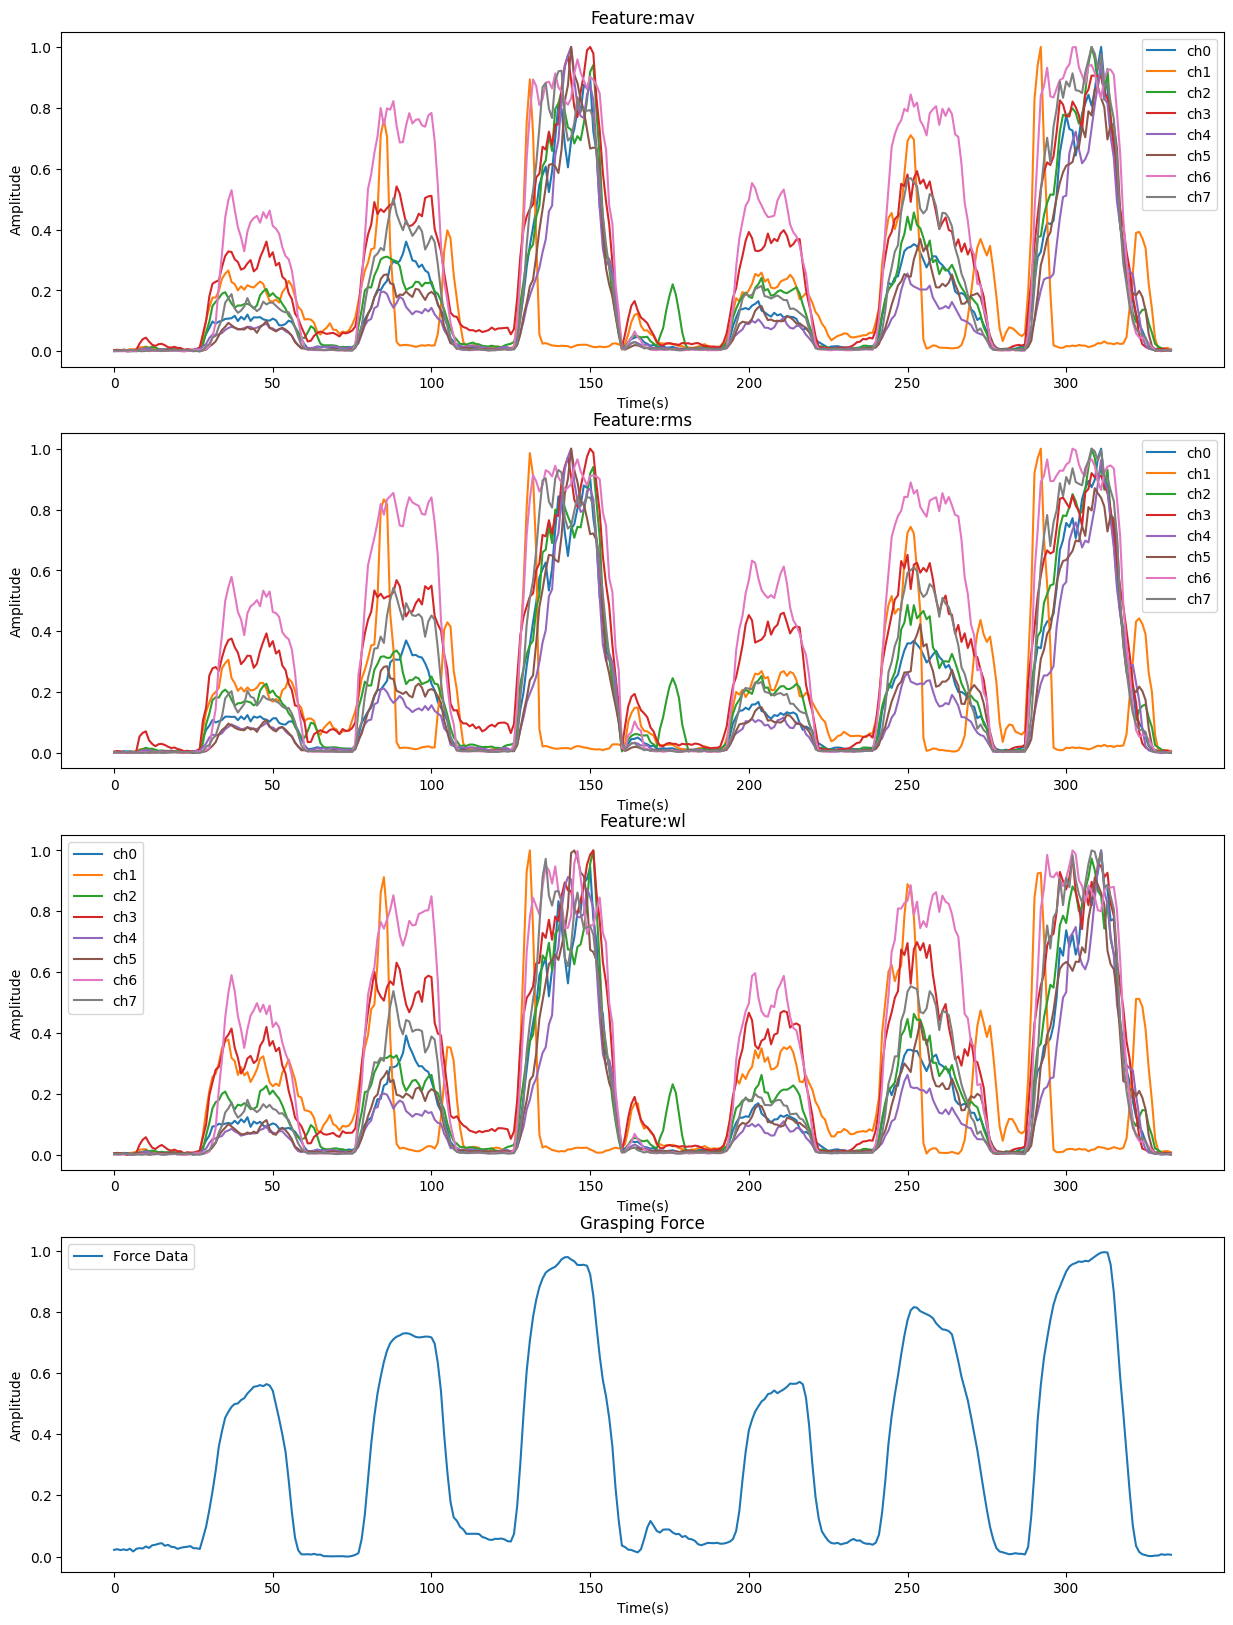

In [26]:
fig, axs = plt.subplots(features.shape[2]+1, 1, figsize=(15, 20))
colors_list=['#129845','#271254','#FA4411']
for n,feature in enumerate(features_name):
    axs[n].set_title(f'Feature:{feature}')

    axs[n].plot(features[:,:,n].T)
    axs[n].set_ylabel('Amplitude')
    axs[n].set_xlabel('Time(s)')
    axs[n].legend([f'ch{ch}'for ch in range(n_channels)])

axs[-1].plot(force_ds.T)
axs[-1].legend(['Force Data'])
axs[-1].set_title(f'Grasping Force')
axs[-1].set_ylabel('Amplitude')
axs[-1].set_xlabel('Time(s)')
plt.savefig('EMG_force_datalog/Extracted_Features_fig.png')
plt.show()

## State Space Identification System

* Selecting the used channels

In [14]:
# select the used channels
used_channels=[5,6,7]

* System order, input array and output array definitions

In [15]:
# Definition of input u
u = np.hstack([features[channel] for channel in used_channels]).T
u[:, :10] = np.zeros((u.shape[0], 10))

# Output signal (grasping force data)
y = force_ds
# separe half of data to train 
nit_train = (len(y) // 2) -1

# Define system order and number of inputs
n = 4  # system order
N_i = u.shape[0]  # number of inputs

# Proposition of measured/observed states
yi = y[:nit_train].copy()
ui = u[:nit_train].copy()

* System states

In [16]:
# System State for order n
X = np.zeros((len(y), n))
X[:, 0] = y.T
for k in range(1, len(y)):
    for j in range(1, n):
        X[k, j] = (X[k, j-1] - X[k-1, j-1]) / Ts

* Parameter's Initial conditions

In [17]:
# Define parameters
lambda_ = 1  # forgetting factor
I = np.eye(2 * n + N_i)  # Initialize identity matrix

# Initialize variables
e = np.zeros(5)
theta_hat = 0.01* np.ones((2 * n + N_i, n))  # initial parameter vector
P = np.eye(2 * n + N_i)  # initial covariance matrix
Yhat = np.zeros((nit_train,1))  # estimated outputs vector
Xhat = np.zeros((nit_train, n))  # estimated states vector
PHI = np.zeros((2 * n + N_i, 1))  # data vector
W = Xhat.copy()
TRACOP = np.zeros(nit_train)
Xi = X[:nit_train, :]

* Recursive Least Squares (RLS) Algorithm


In [18]:

# Recursive Least Squares (RLS)
for t in range(4, nit_train):
    PHI = np.hstack([Xi[t-1, :], ui[:, t-1], W[t-1, :]]).reshape(-1, 1)
    
    # (1) Calculate the model's estimated output at instant k, yhat
    xhat = PHI.T @ theta_hat
    yhat = np.array([1] + [0] * (n-1)) @ xhat.T
    
    # Store the obtained outputs in the Yhat vector
    Xhat[t, :] = xhat
    Yhat[t] = yhat
    
    # (2) Calculate the estimation error at instant k
    ex = Xi[t, :n] - xhat.flatten()
    ek = y[t] - yhat
    e = np.append(e, ek)
    
    # (3) Calculate the estimator gain vector
    denominator = lambda_ + PHI.T @ P @ PHI
    K = (P @ PHI) / denominator
    
    # (4) Update the parameter vector estimate theta_hat
    theta_hat = theta_hat + K @ ex.reshape(-1, 1).T
    
    # Small noise, stochastic process
    W[t, :] = Xi[t, :n] - (PHI.T @ theta_hat).flatten()
    
    # (5): Update the covariance matrix
    P = (I - K @ PHI.T) @ P / lambda_
    TRACOP[t] = np.trace(P)

# Obtained state-space model
AB = theta_hat.T
A = AB[:n, :n]
B = AB[:n, n:n + N_i]
GAMA = AB[:n, n + N_i:]
C = np.array([1] + [0] * (n-1))

print("A:", A)
print('--------------------------------------------------------------------------')
print("B:", B)
print('--------------------------------------------------------------------------')
print("GAMA:", GAMA)
print('--------------------------------------------------------------------------')
print("C:", C)


A: [[ 5.14177100e-01  4.30193118e-03  1.08605944e-05 -3.20639685e-08]
 [-1.97553702e+00  8.51530562e-01  1.88313230e-03 -8.37752137e-06]
 [-3.94634648e+02 -2.96747984e+01  3.76604295e-01 -1.67460097e-03]
 [-7.89264487e+04 -5.93496011e+03 -1.24679152e+02 -3.34920166e-01]]
--------------------------------------------------------------------------
B: [[ 2.02513346e-02  1.80400790e-02  2.12405528e-02  9.95884355e-02
   1.38832049e-01  1.21776204e-01  3.86238570e-02  4.23188713e-02
   2.76870811e-02]
 [ 4.47199676e-01  1.97304265e-01 -2.29201217e-01 -7.05848275e-01
   9.56729364e-01  4.46704519e-01  2.12316426e-01 -1.75232858e-01
   2.66834580e-02]
 [ 8.93557179e+01  3.94918900e+01 -4.58561568e+01 -1.41352049e+02
   1.91401702e+02  8.91710279e+01  4.23006861e+01 -3.50833210e+01
   5.16609732e+00]
 [ 1.78709857e+04  7.89828870e+03 -9.17130820e+03 -2.82704826e+04
   3.82803170e+04  1.78340905e+04  8.46005135e+03 -7.01669604e+03
   1.03308900e+03]]
---------------------------------------------

* Identified Model Test

In [19]:
# use functions to comput the R2 score and NRME
R2_coef=pp.R2Calculator()
NRMSE = pp.NRMSECalculator()

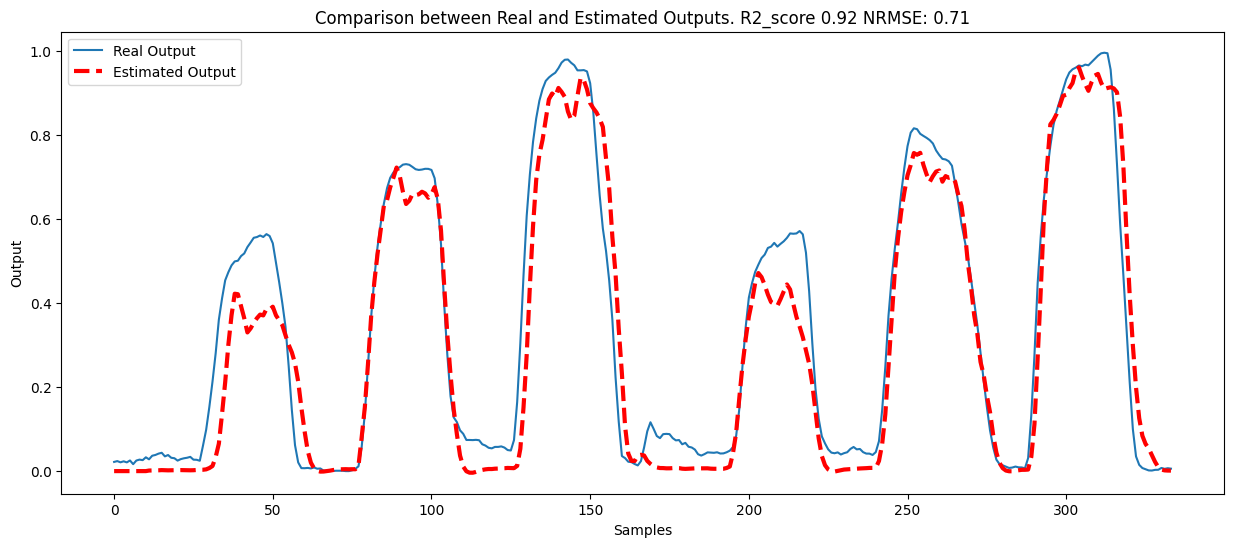

In [20]:
# Test the identified model
nit = len(y)
xest = np.zeros((n, nit))
yest = np.zeros(nit)
for k in range(10, nit):
    # Estimated plant output
    xest[:, k] = A @ xest[:, k-1] + B @ u[:, k-1]
    # Uncomment the next line if needed and define ex
    # xest[:, k] += GAMMA @ ex  
    yest[k] = C @ xest[:, k]

# Convert yest to a 1D array
yest = yest.flatten()

R2_SS=R2_coef(y,yest)
NRMSE_SS = NRMSE(y,yest)
# Display results
plt.figure(figsize=(15, 6))
plt.plot(y, label='Real Output')
plt.plot(yest, label='Estimated Output', linestyle='--', linewidth = 3, color = 'red')
plt.legend()
plt.xlabel('Samples')
plt.ylabel('Output')
plt.title(f'Comparison between Real and Estimated Outputs. R2_score {R2_SS:.2f} NRMSE: {NRMSE_SS:.2f}')
plt.show()

## Estimation with Kalman Filter (minimum variance case) 

In [21]:
dqlr = pp.DLQRCalculator()

* Initial parameters

In [22]:
# Initialize variables and parameters
n = 4  # system order
W = X - xest.T
V = y - yest

# Calculate Qfk and Rfk
#Qfk = np.diag(np.var(W, axis=0))
Qfk = np.cov((W.T @ W), rowvar=False)
Qfk = GAMA @ Qfk @ GAMA.T

Rfk = np.var(W[:, 0])
# Compute Kalman gain
#L, K, = dqlr(A.T, C.reshape(-1, 1), Qfk, Rfk)

# Initialize state variables
xfk = np.zeros((n, 1))
x = np.zeros((n, 1))
yfk = np.zeros(len(y))
y_ = np.zeros(len(y))
time_measurements = np.zeros(len(y))



* Get Kaman Gain

In [23]:
L, P = dqlr(A,C.reshape(1,-1),Qfk,Rfk)

* Force estimed with Kalman filter

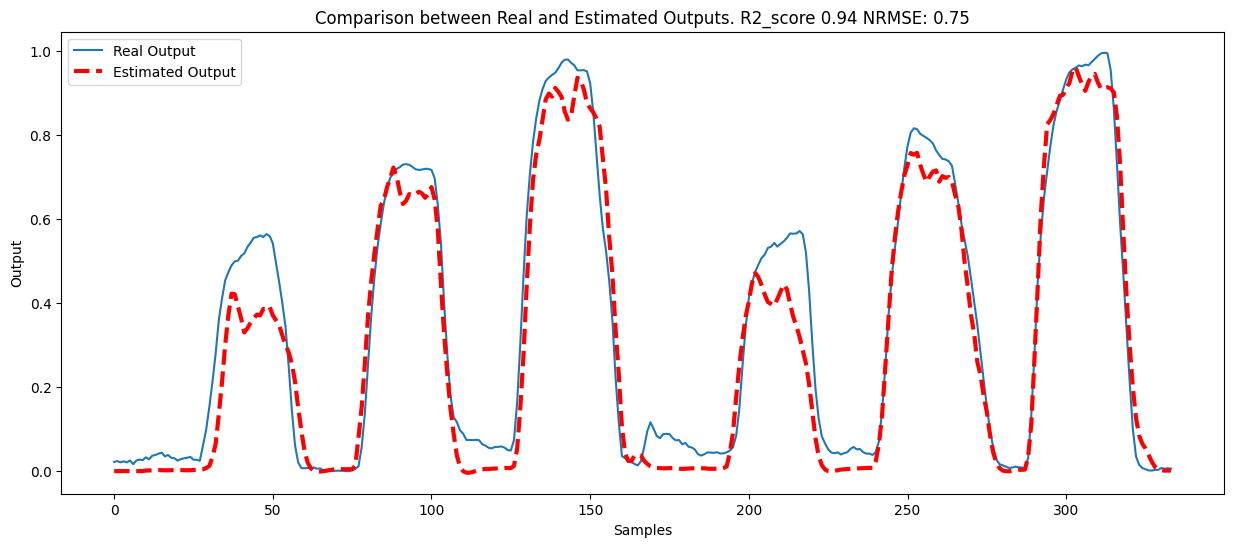

In [24]:
# Estimation using Kalman filter
x_est = np.zeros((n, nit))
x_fk = np.zeros((n, nit)) 
y_est = np.zeros(nit)

for k in range(10, nit):
    # Plant output estimation
    xest[:, k] = A @ xest[:, k-1] + B @ u[:, k-1]

    y_[k] = C @ xest[:, k]

    # Observer                       A-LC * xfk                                         B.U                        Ly
    x_fk[:, k] = (((A -L @ C.reshape(1,-1)) @ x_fk[:, k-1].reshape(-1,1)) + B @ u[:, k].reshape(-1,1) + L @ y_[k].reshape(-1,1)).T
    y_est[k] = C @ x_fk[:,k]

R2_SS_FK=R2_coef(y,y_est)
NRMSE_SS_FK = NRMSE(y,y_est)
# Display results
plt.figure(figsize=(15, 6))
plt.plot(y, label='Real Output')
plt.plot(y_est, label='Estimated Output', linestyle='--', linewidth = 3, color = 'red')
plt.legend()
plt.xlabel('Samples')
plt.ylabel('Output')
plt.title(f'Comparison between Real and Estimated Outputs. R2_score {R2_SS_FK:.2f} NRMSE: {NRMSE_SS_FK:.2f}')
plt.show()